In [67]:
cd /content/drive/MyDrive/Customer Segmentation

/content/drive/MyDrive/Customer Segmentation


# Import Libraries

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
# scipy
from scipy.cluster.hierarchy import linkage, dendrogram
# save/load models
import pickle
from tensorflow.keras.models import load_model


sns.set(style="white", palette="Set2", color_codes=True)



import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Import Data:

In [69]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [70]:
df.shape

(200, 5)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


# Notes:


*   Drop unneccessary column "CustomerID".
*   Rename columns to make them easier to deal with.
*   Encode "Gender" Column.





In [72]:
df_c = df.copy()
df_c.drop(columns = 'CustomerID', inplace = True)
df_c.rename(columns = {'Annual Income (k$)':'Income', 'Spending Score (1-100)': 'Spending'}, inplace = True)
df_c.Gender.replace({'Male': 0, 'Female': 1}, inplace = True)
df_c.Gender = df_c.Gender.astype('category')
# check
df_c.head()


,Gender,Age,Income,Spending
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40


# EDA:

In [73]:
df_c[['Age', 'Income', 'Spending']].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
Income,200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0
Spending,200.0,50.20,25.823522,1.0,34.75,50.0,73.0,99.0


In [74]:
df_c['Gender'].describe()

count     200
unique      2
top         1
freq      112
Name: Gender, dtype: int64

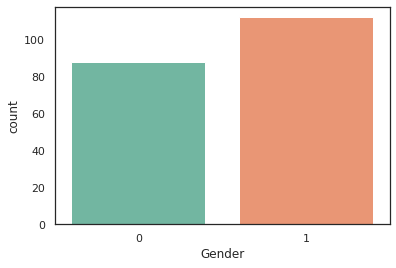

In [75]:
sns.countplot(df_c.Gender);

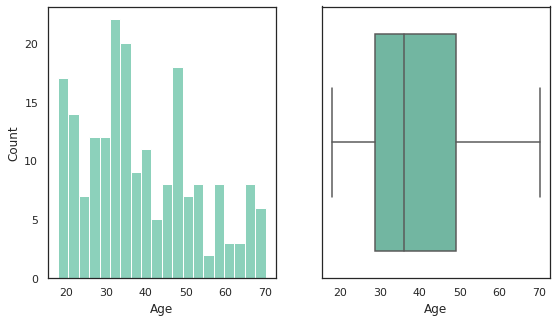

In [76]:
fig, axes = plt.subplots(1, 2, figsize = (9, 5))
sns.histplot(df_c.Age, bins= 20, ax = axes[0])
sns.boxplot(df_c.Age, ax = axes[1]);

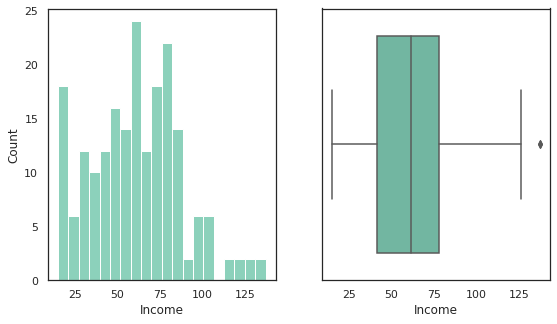

In [77]:
fig, axes = plt.subplots(1, 2, figsize = (9, 5))
sns.histplot(df_c.Income, bins= 20, ax = axes[0])
sns.boxplot(df_c.Income, ax = axes[1]);

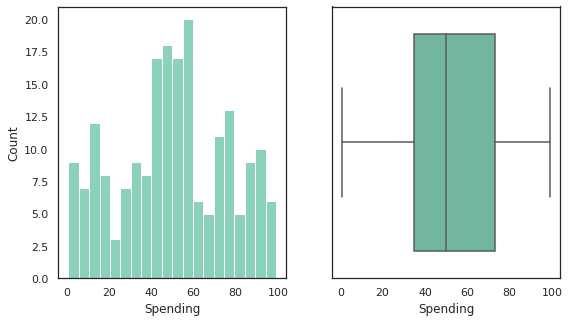

In [78]:
fig, axes = plt.subplots(1, 2, figsize = (9, 5))
sns.histplot(df_c.Spending, bins= 20, ax = axes[0])
sns.boxplot(df_c.Spending, ax = axes[1]);

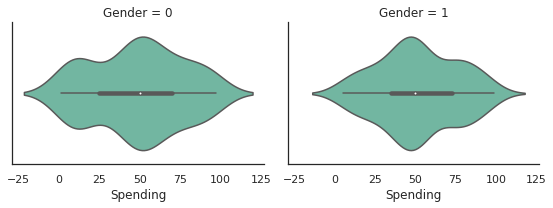

In [79]:
g = sns.FacetGrid(col = 'Gender', data = df_c, aspect = 1.3)
g.map(sns.violinplot, 'Spending');


In [80]:
df_c.groupby('Gender')['Spending'].describe()

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
0,88.0,48.511364,27.89677,1.0,24.5,50.0,70.0,97.0
1,112.0,51.526786,24.11495,5.0,35.0,50.0,73.0,99.0


*Females have a wider range for spending than males, however females tend to spend less than Males.*

*We need to check for the income of both genders:*

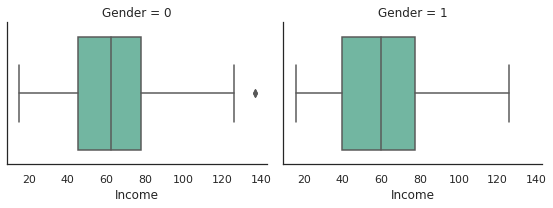

In [81]:
g2 = sns.FacetGrid(col = 'Gender', data = df_c, aspect = 1.3)
g2.map(sns.boxplot, 'Income');

In [82]:
df_c.groupby('Gender')['Income'].describe()

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
0,88.0,62.227273,26.638373,15.0,45.50,62.5,78.00,137.0
1,112.0,59.250000,26.011952,16.0,39.75,60.0,77.25,126.0


*The difference in Income for the two genders is very small.*

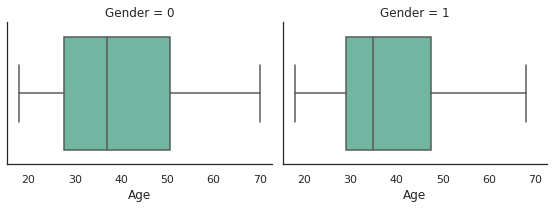

In [83]:
g3 = sns.FacetGrid(col = 'Gender', data = df_c, aspect = 1.3)
g3.map(sns.boxplot, 'Age');

In [84]:
df_c.groupby('Gender')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
0,88.0,39.806818,15.514812,18.0,27.75,37.0,50.5,70.0
1,112.0,38.098214,12.644095,18.0,29.00,35.0,47.5,68.0


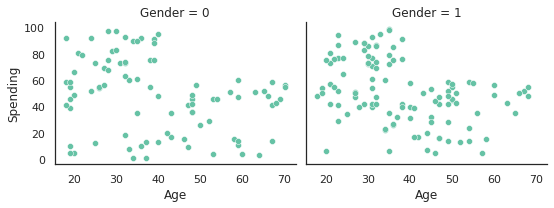

In [85]:
g4 = sns.FacetGrid(col = 'Gender', data = df_c, aspect = 1.3)
g4.map(sns.scatterplot, 'Age', 'Spending');

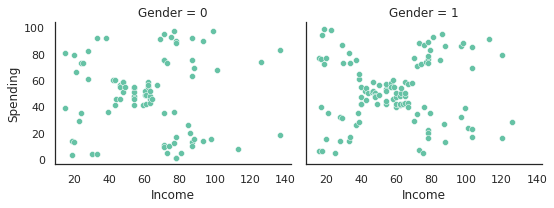

In [86]:
g4 = sns.FacetGrid(col = 'Gender', data = df_c, aspect = 1.3)
g4.map(sns.scatterplot, 'Income', 'Spending');

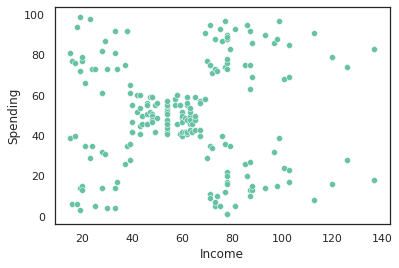

In [87]:
sns.scatterplot('Income', 'Spending', data = df_c);

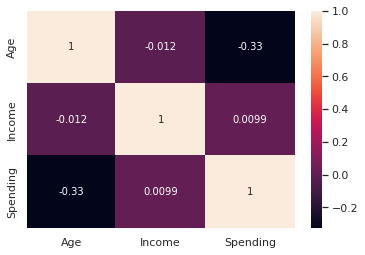

In [88]:
sns.heatmap(df_c.corr('pearson'), annot = True);

# Insights:


*   Age has a negative correlation with Spending
*   Female spending covers a bigger range than males, starting with small amounts of money.


# Preprocessing:

## K-means:

elbow method to get insight which k to use:

In [89]:
inertia = []
for i in range(1,11):
  km = KMeans(n_clusters=i, init='k-means++', random_state=21).fit(df_c)
  inertia.append(km.inertia_)

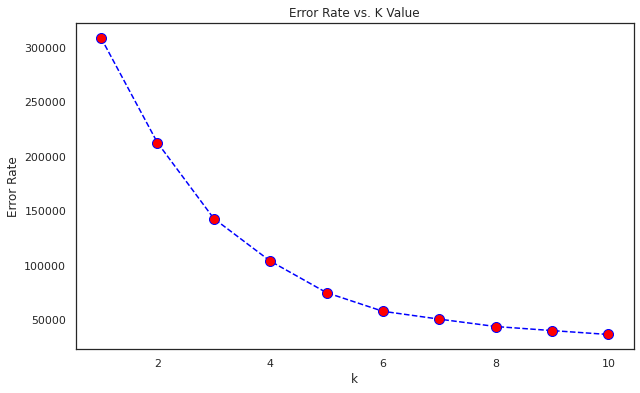

In [90]:
plt.figure(figsize=(10,6)) 
plt.plot(range(1, 11),inertia, color='blue', linestyle='dashed', marker='o', 
 markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value') 
plt.xlabel('k') 
plt.ylabel('Error Rate')
plt.show();

In [91]:
km = KMeans(n_clusters=5, random_state=42)
km_pred = km.fit_predict(df_c)
plot_km= df_c.copy()
plot_km['Cluster'] = km_pred

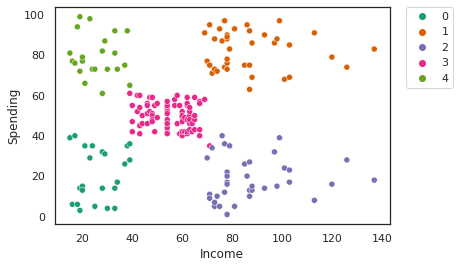

In [92]:
sns.scatterplot('Income', 'Spending', data= plot_km, hue = 'Cluster', palette= 'Dark2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0);


In [93]:
pickle.dump(km, open('kmeans.pkl', 'wb'))


## Conclusion:
**We have five group, two with lower income and different spending rate, one with average income and average spending rate, the last two groups have a higher income but one of them has a low spending rate.**

## Agglomerative Hierarchical Clustering:

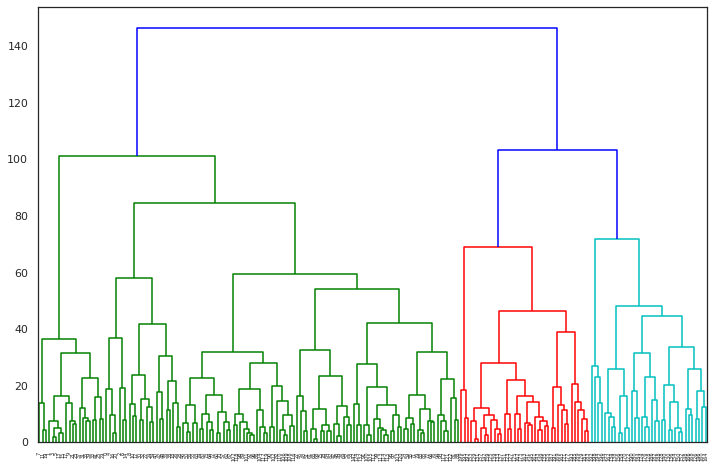

In [94]:
l = linkage(df_c, method='complete', metric='euclidean')
plt.figure(figsize= (12, 8))
dendrogram(l, show_leaf_counts=False);

In [95]:
hc = AgglomerativeClustering(5, affinity='euclidean', linkage='complete', compute_full_tree=False)
hc_pred = hc.fit_predict(df_c)
plot_hc=df_c.copy()
plot_hc["Cluster"]=hc_pred

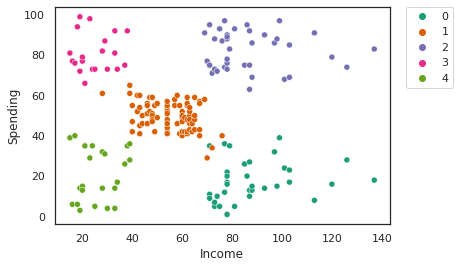

In [96]:
sns.scatterplot('Income', 'Spending', data= plot_hc, hue = 'Cluster', palette= 'Dark2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0);

In [97]:
pickle.dump(hc, open('hac.pkl', 'wb'))


## DBSCAN:

In [98]:
db=DBSCAN(eps=15, min_samples=11, metric='euclidean')
db_preds=db.fit_predict(df_c)
plot_db=df_c.copy()
plot_db['Cluster'] = db_preds

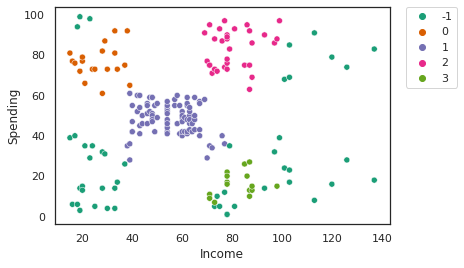

In [100]:
sns.scatterplot('Income', 'Spending', data= plot_db, hue = 'Cluster', palette= 'Dark2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0);

In [101]:
plot_db.Cluster.value_counts(normalize  = True)

 1    0.430
-1    0.240
 2    0.160
 0    0.095
 3    0.075
Name: Cluster, dtype: float64

In [102]:
pickle.dump(db, open('dbscan.pkl', 'wb'))


### Conclusion:
*The DBSCAN results in four clusters and outliers, the outliers represent about 25% of the data considered as outliers, as the DBSCAN rely heavily on the density.